In [ ]:
# Core
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union, Any, Callable

## Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns

## Harp/Bonsai
sys.path.append('../../src/')
from bonsai import load_bonsai_config
load_bonsai_config(r"C:\git\AllenNeuralDynamics\aind-vr-foraging\Bonsai")
import harp
import harp.processing
import data_io

#Global Viz settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

default_img_size = (15, 8)

## From GitHub

[aind-vr-foraging Issue #81](https://github.com/AllenNeuralDynamics/aind-vr-foraging/issues/81)


### Notes:

- Sessions from 10/10/2023
    - 102
      - 7, 18.10, 28.47, 31.57
    - 103
      - 9.23, 10.06, 12.33, 15.08, 29.36 (manually given water), 38.11, 49.23
    - 107
      - 9.17, 10.29, 11.18, 13.40, 15.19


1. Check for Reward Sites
2. Check for ChoiceFeedback
3. Check for Licks
4. Check for GiveReward
5. Check the valve events (both time and onset)


In [ ]:
session_path = Path(r"Z:\scratch\vr-foraging\672107\20231012T121158")


# Harp Devices:
HarpBehavior = harp.HarpDevice("Behavior")
harp_behavior_data = data_io.HarpSource(device=HarpBehavior, path=session_path / "Behavior", name="behavior", autoload=False)

software_events = data_io.SoftwareEventSource(path=session_path / "SoftwareEvents", name="software_events", autoload=True)
config = data_io.ConfigSource(path=session_path / "Config", name="config", autoload=True)
operation_control = data_io.OperationControlSource(path=session_path / "OperationControl", name="config", autoload=False)

def add_position(df: pd.DataFrame, position: data_io.DataStream):

    df = pd.merge_asof(df.sort_index(), position.data.sort_index(), direction='nearest', on="Seconds").set_index("Seconds").sort_index()
    df.columns = [*df.columns[:-1], 'Position']
    return df


In [ ]:
# Find reward sites
sites = software_events.streams.ActiveSite.data
reward_sites = sites.loc[sites["data"].apply(lambda x : x['label'] == 'Reward'), :]

# Find ChoiceFeedback events (i.e. successful stops)
choice_feedback = software_events.streams.ChoiceFeedback.data

# Check for licks

## mask for digital inputs
digital_inputs = HarpBehavior.module.DigitalInputs

harp_behavior_data.streams.DigitalInputState.load_from_file()
di_state = harp_behavior_data.streams.DigitalInputState.data
di_port0 = di_state["Value"].apply(lambda x : x.HasFlag(digital_inputs.DIPort0))
di_port0 = di_port0.loc[di_port0.diff() == True]
lick_onset = di_port0.loc[di_port0 == True]

# Find give reward event
give_reward = software_events.streams.GiveReward.data

zero_index = reward_sites.index[0]

# Find hardware reward events

harp_behavior_data.streams.PulseSupplyPort0.load_from_file() # Duration of each pulse
pulse_duration = harp_behavior_data.streams.PulseSupplyPort0.data
digital_outputs = HarpBehavior.module.DigitalOutputs
harp_behavior_data.streams.OutputSet.load_from_file()
valve_output_pulse = harp_behavior_data.streams.OutputSet.data
valve_output_pulse = valve_output_pulse.loc[valve_output_pulse["Value"].apply(lambda x: x.HasFlag(digital_outputs.SupplyPort0))]


valve_output_pulse['pulse_duration'] = -1
for seconds, contents in valve_output_pulse.iterrows():
    idx, _ = harp.processing.find_closest(seconds, pulse_duration.index.values, mode='below_zero')
    if not np.isnan(idx):
        valve_output_pulse.loc[seconds, 'pulse_duration'] = pulse_duration.iloc[idx].Value

print(valve_output_pulse["pulse_duration"].unique())


harp_behavior_data.streams.OutputSet.load_from_file()
harp_behavior_data.streams.OutputClear.load_from_file()
odor_0 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort1)
odor_1 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort2)

odors_onset = pd.concat(
    [
        odor_0[odor_0["Value"]].assign(Value=0),
        odor_1[odor_1["Value"]].assign(Value=1),
    ], axis=0, copy=True).sort_index()




# Start plotting raster
plt.figure(figsize=(25,5))
plt.scatter(odors_onset.index - zero_index, odors_onset["Value"] * 0.3 - 0.15, marker="|", s=100, c="m", label="OdorOnset")
plt.scatter(reward_sites.index - zero_index, reward_sites.index * 0 + 1, marker="|", s=100, c="r", label="RewardSite")
plt.scatter(choice_feedback.index - zero_index, choice_feedback.index * 0 + 2, marker="|", s=100, c="g", label="ChoiceFeedback")
plt.scatter(lick_onset.index - zero_index, lick_onset.index * 0 + 3, marker="|", s=100, c="k", label="Lick")
plt.scatter(give_reward.index - zero_index, (give_reward["data"] *0.3 ) - 0.15 + 4, marker="|", s=100, c="b", label="Reward")
plt.scatter(valve_output_pulse.index - zero_index, valve_output_pulse.index*0 + 5 , marker="|", s=100, c="c", label="ValveOpen")


label_cm = sns.color_palette('hls', len(sites["data"].apply(lambda x : x["label"]).unique()))
label_dict = {label : color for label, color in zip(sites["data"].apply(lambda x : x["label"]).unique(), label_cm)}

for idx, site in enumerate(sites.iloc[:-1].iterrows()):
    p = Rectangle(
        (sites.index[idx] - zero_index, 0), sites.index[idx+1] - sites.index[idx], 6,
        linewidth = 0, facecolor = label_dict[site[1]["data"]["label"]], alpha = 0.2 )
    plt.gca().add_patch(p)


plt.gca().set_yticklabels([])
plt.xlabel("Time(s)")
plt.legend()
plt.xlim((400, 500))
plt.show()


In [ ]:
# Start plotting raster
operation_control.streams.CurrentPosition.load_from_file()
position = operation_control.streams.CurrentPosition
operation_control.streams.IsStopped.load_from_file()
is_stopped = operation_control.streams.IsStopped

plt.figure(figsize=(25,5))
plt.scatter(add_position(odors_onset, position=position)["Position"].values, odors_onset["Value"] * 0.3 - 0.15, marker="|", s=100, c="m", label="OdorOnset")
plt.scatter(add_position(reward_sites, position=position)["Position"].values, reward_sites.index * 0 + 1, marker="|", s=100, c="r", label="RewardSite")
plt.scatter(add_position(choice_feedback, position=position)["Position"].values, choice_feedback.index * 0 + 2, marker="|", s=100, c="g", label="ChoiceFeedback")
plt.scatter(add_position(lick_onset, position=position)["Position"].values, lick_onset.index * 0 + 3, marker="|", s=100, c="k", label="Lick")
plt.scatter(add_position(give_reward, position=position)["Position"].values, (give_reward["data"] *0.3 ) - 0.15 + 4, marker="|", s=100, c="b", label="Reward")
plt.scatter(add_position(valve_output_pulse, position=position)["Position"].values, valve_output_pulse.index*0 + 5 , marker="|", s=100, c="c", label="ValveOpen")


label_cm = sns.color_palette('hls', len(sites["data"].apply(lambda x : x["label"]).unique()))
label_dict = {label : color for label, color in zip(sites["data"].apply(lambda x : x["label"]).unique(), label_cm)}

_sites = add_position(sites, position=position)
for idx, site in enumerate(sites.iloc[:-1].iterrows()):
    p = Rectangle(
        (_sites["Position"].iloc[idx], 0), _sites["Position"].iloc[idx+1] - _sites["Position"].iloc[idx], 6,
        linewidth = 0, facecolor = label_dict[site[1]["data"]["label"]], alpha = 0.2 )
    plt.gca().add_patch(p)


plt.gca().set_yticklabels([])
plt.xlabel("VrSpace(cm)")
plt.legend()
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sites["label"] = sites.apply(lambda x : x["data"]["label"], axis=1)
for i, (label, group) in enumerate(sites.groupby("label")):
    size = group.apply(lambda x : x["data"]["length"], axis=1)
    axs[i].hist(size.values, bins= np.arange(30, 100, 2.5), density = 1)
    axs[i].vlines(size.mean(), 0, 0.1, color="r", label="Mean")
    axs[i].set_title(f"{label} // Mean: {size.mean():.2f}")
    axs[i].set_xlabel("Length (cm)")
    if i == 0:
        axs[i].set_ylabel("Density")
    axs[i].set_xlim((30, 100))
plt.show()

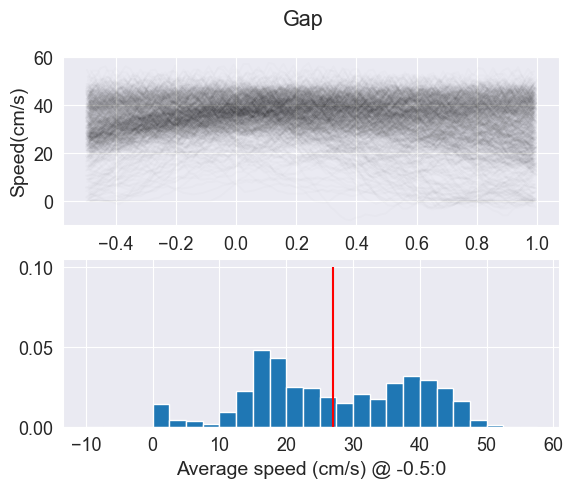

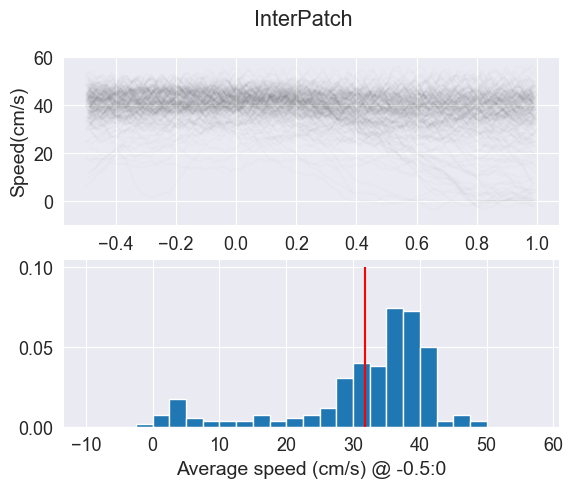

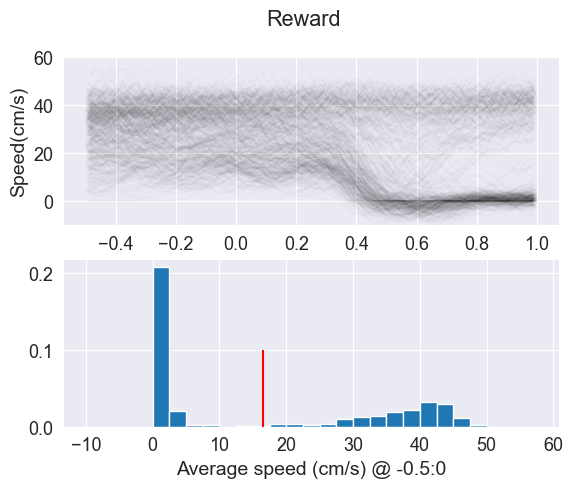

In [38]:
# align on site entry

treadmill_metadata = config.streams.Rig.data["treadmill"]
encoder = harp.read_harp_bin(harp_behavior_data.streams.AnalogData.path).iloc[:,1]
converter = treadmill_metadata["wheelDiameter"] * np.pi / treadmill_metadata["pulsesPerRevolution"] * (-1 if treadmill_metadata["invertDirection"] else 1)
encoder = encoder.apply(lambda x : x * converter)
encoder.index = pd.to_datetime(encoder.index, unit="s")
encoder = encoder.resample("16.6ms").sum().interpolate(method="linear") / 0.0166
encoder.index = (encoder.index - pd.to_datetime(0))
encoder.index = encoder.index.total_seconds()

window = (-0.5, 1)
for label, label_group in sites.groupby("label"):
    fig, axs = plt.subplots(2,1)
    dist = []
    for index, site in label_group.iterrows():
        this_window = np.array((index - window[0], index + window[1]))
        trace = encoder.loc[index + window[0] : index + window[1]]
        dist.append(encoder.loc[index + window[0] : index].values.mean())
        axs[0].plot(trace.index - index, trace.values, color = 'k', alpha=0.01)

    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Speed(cm/s)")
    axs[0].set_ylim((-10, 60))

    axs[1].hist(np.array(dist), bins=np.arange(-10, 60, 2.5), density=1)
    axs[1].vlines(np.array(dist).mean(), 0, 0.1, color="r", label="Mean")
    axs[1].set_xlabel(f"Average speed (cm/s) @ {window[0]}:{0}")
    fig.suptitle(label)
